1. Возьмите датасет с цветками iris’а (функция load_iris из библиотеки sklearn)
1. Оставьте два признака - sepal_length и sepal_width и целевую переменную - variety
1. Разделите данные на выборку для обучения и тестирования
1. Постройте модель LDA
1. Визуализируйте предсказания для тестовой выборки и центры классов
1. Отбросьте целевую переменную и оставьте только два признака - sepal_length и sepal_width
1. Подберите оптимальное число кластеров для алгоритма kmeans и визуализируйте полученную кластеризацию

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Сформируем датафрейм, отвечающий условиям домашнего задания

In [2]:
iris_data_dict = load_iris()
df_iris = pd.DataFrame(iris_data_dict.data[:, 0:2], columns=iris_data_dict.feature_names[:2])
df_iris['variety'] = iris_data_dict.target
df_iris[:10]

,sepal length (cm),sepal width (cm),variety
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
5,5.4,3.9,0
6,4.6,3.4,0
7,5.0,3.4,0
8,4.4,2.9,0
9,4.9,3.1,0


In [3]:
df_iris.describe()

,sepal length (cm),sepal width (cm),variety
count,150.000000,150.000000,150.000000
mean,5.843333,3.057333,1.000000
std,0.828066,0.435866,0.819232
min,4.300000,2.000000,0.000000
25%,5.100000,2.800000,0.000000
50%,5.800000,3.000000,1.000000
75%,6.400000,3.300000,2.000000
max,7.900000,4.400000,2.000000


Чтобы использовать дискриминантный анализ необходимо обеспечить следующие условия для выборки:

- нормальное распределение
- похожесть дисперсии
- низкая корреляция признаков

Проверим наши данные на соответствие этим условиям.

Стандартное отклонения ширины 0.44, а длины 0.83. Можно считать различие в СКО несущественным.

Посмотрим является ли распределение нормальным.

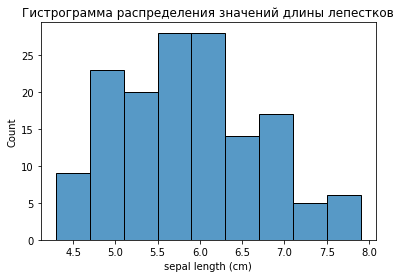

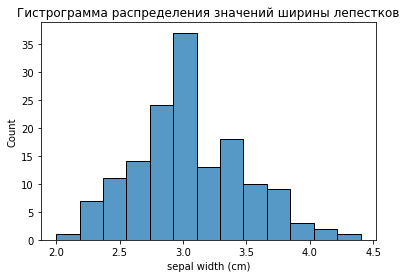

In [4]:
sns.histplot(df_iris['sepal length (cm)'])
plt.title('Гистрограмма распределения значений длины лепестков')
plt.show()
plt.title('Гистрограмма распределения значений ширины лепестков')
sns.histplot(df_iris['sepal width (cm)'])
plt.show()

Как видно ширина лепестков имеет распределение, близкое к нормальному. Но длина лепестков от нормального отличается уже больше. Поэтому дискриминантный анализ может давать небольшие ошибки. При этом выбросов не наблюдается.

Данные можно считать непрерывными.

Проверим значения коэффициентов корреляции Пирсона и Кенделла.

In [5]:
df_iris[['sepal length (cm)','sepal width (cm)']].corr()

,sepal length (cm),sepal width (cm)
sepal length (cm),1.00000,-0.11757
sepal width (cm),-0.11757,1.00000


In [6]:
df_iris[['sepal length (cm)','sepal width (cm)']].corr(method='kendall')

,sepal length (cm),sepal width (cm)
sepal length (cm),1.000000,-0.076997
sepal width (cm),-0.076997,1.000000


Как видим, мы получили крайне низкие значения корреляции. В связи с этим можно сделать вывод, что метод дискриминантного анализа применить можно, но из-за небольших отклонений от нормального распределения у нас возможны небольшие ошибки.

Разделим выборки на тестовые и тренировочные.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_iris[['sepal length (cm)', 'sepal width (cm)']],
                                                                      df_iris['variety'],
                                                                      test_size = 0.3,
                                                                      random_state = 72)

In [8]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
predict = lda.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, predict)}')


Accuracy Score: 0.8222222222222222


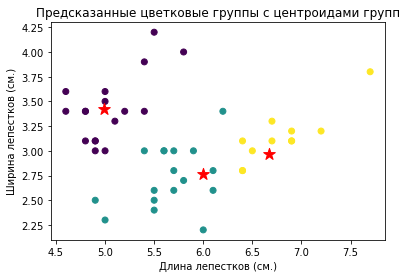

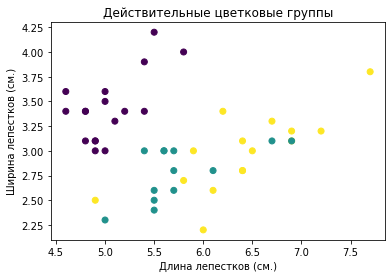

In [9]:
plt.scatter(X_test['sepal length (cm)'],X_test['sepal width (cm)'], c=predict)
plt.title('Предсказанные цветковые группы с центроидами групп')
plt.xlabel('Длина лепестков (см.)')
plt.ylabel('Ширина лепестков (см.)')
# центроиды
plt.scatter(lda.means_[:, 0], lda.means_[:, 1], c='r', s=150, marker='*')
plt.show()

plt.scatter(X_test['sepal length (cm)'],X_test['sepal width (cm)'], c=y_test)
plt.title('Действительные цветковые группы')
plt.xlabel('Длина лепестков (см.)')
plt.ylabel('Ширина лепестков (см.)')
plt.show()

Как видим есть ошибки определения групп. Это связано с пересечением значений в 2 группах в исходных значениях и вероятно в для получения более точных результатов нужно добавлять дополнительные признаки в наш набор данных.

Попробуем определить группы с помощью алгоритма кластеризации к-среднего. Для начала найдем оптимальное количество кластеров с помощью метода локтя.

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

k_inertia = []
ks = range(1,20)
for k in ks:
    kmean = KMeans(n_clusters=k)
    kmean.fit(X_train_scaled)
    k_inertia.append(kmean.inertia_)

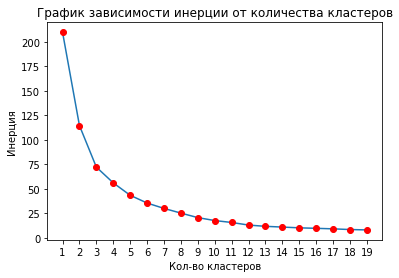

In [11]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia, 'ro')
plt.title('График зависимости инерции от количества кластеров')
plt.xlabel('Кол-во кластеров')
plt.ylabel('Инерция')
plt.xticks(ks)
plt.show()

Судя по полученному графику оптимальный размер кластеров - 4

Теперь определим наши группы с помощью метода к-среднего и построим график.

In [12]:
kmean = KMeans(n_clusters=4)
kmean.fit(X_train_scaled)
clusters = kmean.predict(X_test_scaled)

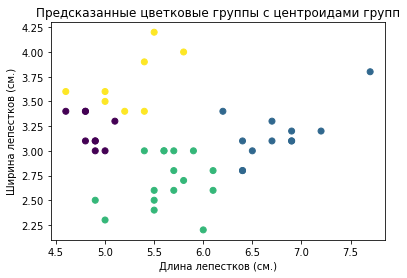

In [13]:
plt.scatter(X_test['sepal length (cm)'],X_test['sepal width (cm)'], c=clusters)
plt.title('Предсказанные цветковые группы с центроидами групп')
plt.xlabel('Длина лепестков (см.)')
plt.ylabel('Ширина лепестков (см.)')
plt.show()